In [28]:
import matplotlib.pylab as plt
import glob
import os.path as op
from itertools import compress
import numpy as np
from matplotlib import gridspec
from utilities import files, tools
import scipy.ndimage.filters as nd
from scipy.interpolate import interp1d
import math
import json
import pandas as pd
from scipy.signal import savgol_filter

json_file = "pipeline_params.json"

In [57]:
def resamp_interp(x, y, new_x):
    """
    returns resampled an interpolated data
    """
    resamp = interp1d(x, y, kind='slinear', fill_value='extrapolate')
    new_data = resamp(new_x)
    return new_data

def to_polar(x, y):
    radius = []
    angle = []
    xy = zip(x, y)
    for x, y in xy:
        rad, theta = tools.cart2polar(x, y)
        theta = math.degrees(theta)
        angle.append(theta)
        radius.append(rad)
    del xy
    radius = np.array(radius)
    angle = np.array(angle)
    return [angle, radius]

def nan_cleaner(arr):
    """
    clears nan values and interpolates the missing value
    """
    mask = np.isnan(arr)
    arr[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), arr[~mask])
    return arr


def calculate_degs(angle, radius):
    degs = np.diff(angle)
    degs = np.insert(degs, 0, 0)
    degs[np.abs(degs) > 300] = np.nan
    degs = nan_cleaner(degs)
    degs = degs * radius
    return degs

In [2]:
with open(json_file) as pipeline_file:
    pipeline_params = json.load(pipeline_file)

In [16]:
beh_path = op.join(pipeline_params["data_path"], "BEH", "0666")
csv_files = files.get_files(beh_path, "ses", ".csv")[2]
csv_files.sort()

In [18]:
csv_file = csv_files[0]
npy_folder = csv_file.split(".")[0]

In [22]:
npy_files = files.get_files(npy_folder, "", ".npy")[2]
npy_files.sort()

In [101]:
npy_file = npy_files[67]
joy_data = np.load(npy_file)
x, y, t = joy_data
t = t - t[0]
time = np.linspace(0.0, 1.5, num=375)
x_interp = resamp_interp(t, x, time)
y_interp = resamp_interp(t, y, time)

In [102]:
angle, radius = to_polar(x_interp, y_interp)
degs = calculate_degs(angle, radius)

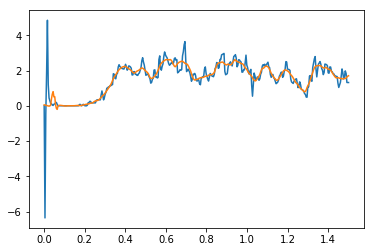

In [103]:
plt.plot(time, degs)
sav_sm = savgol_filter(degs, 25, 2, mode="mirror")
plt.plot(time, sav_sm)

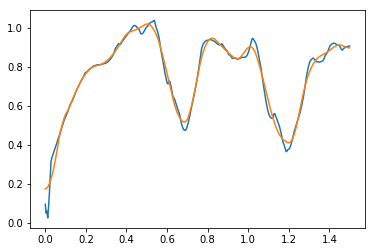

In [106]:
plt.plot(time, radius)
plt.plot(time, savgol_filter(radius, 45, 2, mode="mirror"))

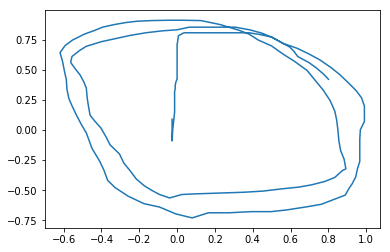

In [105]:
plt.plot(x,-y)